In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read raw data
df_raw = pd.read_csv("./datasets/20A_02.CSV")
df_raw = df_raw.rename(columns = {
    "in s": "t",
    "C1 in V": "Va",
    "C2 in A": "Ia",
    "C3 in V": "n"
})
df_raw

,t,Va,Ia,n
0,-0.024200,0.016113,-0.317383,4.705860
1,-0.024200,-0.042480,-0.122070,4.686330
2,-0.024199,-0.013184,-0.122070,4.647270
3,-0.024199,0.016113,0.024414,4.705860
4,-0.024199,0.001465,-0.170898,4.744920
...,...,...,...,...
999995,0.215799,12.086400,1.293950,0.018359
999996,0.215799,12.071800,1.489260,4.725390
999997,0.215799,12.057100,1.245120,4.647270
999998,0.215800,12.013200,1.293950,4.705860


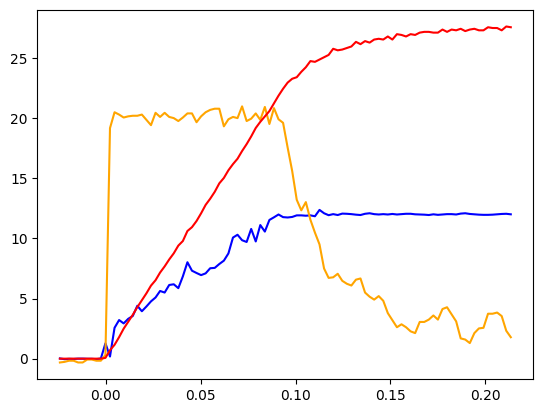

,t,Va,Ia,Wm
0,-0.0242,0.016113,-0.317383,0.000000
10000,-0.0218,-0.042480,-0.268555,0.000000
20000,-0.0194,-0.013184,-0.170898,0.000000
30000,-0.0170,-0.027832,-0.170898,0.000000
40000,-0.0146,0.001465,-0.317383,0.000000
...,...,...,...,...
950000,0.2038,11.969200,3.735350,549.676449
960000,0.2062,11.998500,3.833010,549.676449
970000,0.2086,12.027800,3.540040,545.841497
980000,0.2110,12.042500,2.319340,552.233084


In [46]:
from dcmotor import get_rising_edges

# Downsampling
df_downsampled = pd.DataFrame()

num_steps = 2048
start = True
time_step_raw = df_raw["t"].diff().iloc[1]
batch_size = 10000
time_step = time_step_raw * batch_size

df_downsampled["t"] = df_raw["t"].iloc[::batch_size]
df_downsampled["Va"] = df_raw["Va"].iloc[::batch_size]
df_downsampled["Ia"] = df_raw["Ia"].iloc[::batch_size]
df_downsampled["Wm"] = np.array(get_rising_edges(df_raw["n"].array, 2048, 4, time_step_raw, batch_size)) * np.pi * 2

plt.plot(df_downsampled["t"], df_downsampled["Va"], c="blue")
plt.plot(df_downsampled["t"], df_downsampled["Ia"], c="orange")
plt.plot(df_downsampled["t"], df_downsampled["Wm"]/20, c="red")
plt.show()
df_downsampled

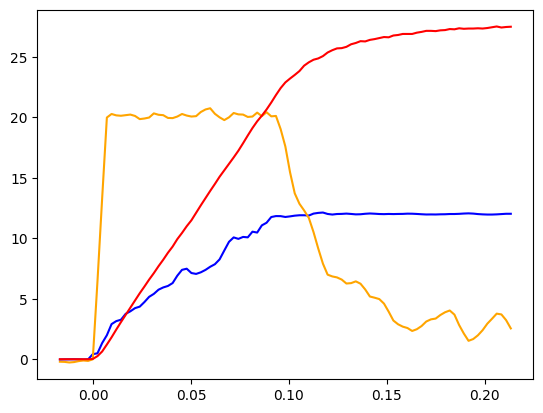

,t,Va,Ia,Wm
30000,-0.0170,-0.027832,-0.203450,0.000000
40000,-0.0146,-0.013184,-0.219726,0.000000
50000,-0.0122,-0.008301,-0.268555,0.000000
60000,-0.0098,-0.003418,-0.236003,0.000000
70000,-0.0074,-0.008301,-0.154622,0.000000
...,...,...,...,...
950000,0.2038,11.959467,3.344727,548.824237
960000,0.2062,11.974100,3.767903,550.102555
970000,0.2086,11.998500,3.702800,548.398132
980000,0.2110,12.022933,3.230797,549.250343


In [67]:
# Low pass filtering
df_filtered = pd.DataFrame()

rolling_width = 3
start_offset = 0

df_filtered["t"] = df_downsampled["t"].iloc[rolling_width+start_offset:]
df_filtered["Va"] = df_downsampled["Va"].rolling(rolling_width).mean().iloc[rolling_width+start_offset:]
df_filtered["Ia"] = df_downsampled["Ia"].rolling(rolling_width).mean().iloc[rolling_width+start_offset:]
df_filtered["Wm"] = df_downsampled["Wm"].rolling(rolling_width).mean().iloc[rolling_width+start_offset:]

plt.plot(df_filtered["t"], df_filtered["Va"], c="blue")
plt.plot(df_filtered["t"], df_filtered["Ia"], c="orange")
plt.plot(df_filtered["t"], df_filtered["Wm"]/20, c="red")
plt.show()
df_filtered

97 101 97
97 101 97


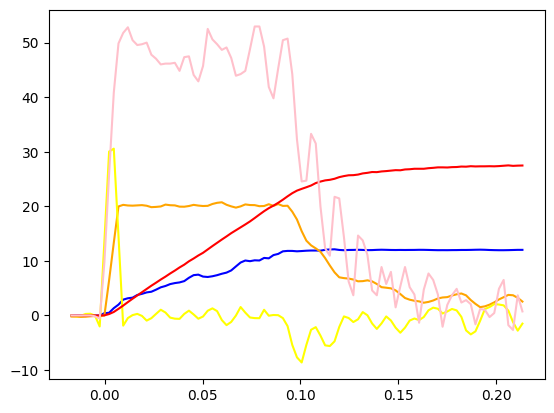

,t,Va,Ia,Wm,dIa,dWm
30000,-0.0170,-0.027832,-0.203450,0.000000,-2.260544,0.000000
40000,-0.0146,-0.013184,-0.219726,0.000000,-16.954245,0.000000
50000,-0.0122,-0.008301,-0.268555,0.000000,-6.216634,0.000000
60000,-0.0098,-0.003418,-0.236003,0.000000,27.691854,0.000000
70000,-0.0074,-0.008301,-0.154622,0.000000,31.647924,0.000000
...,...,...,...,...,...,...
950000,0.2038,11.959467,3.344727,548.824237,185.365625,650.994933
960000,0.2062,11.974100,3.767903,550.102555,89.292245,-177.544073
970000,0.2086,11.998500,3.702800,548.398132,-121.504514,-266.316109
980000,0.2110,12.022933,3.230797,549.250343,-278.613657,369.883485


In [68]:
from dcmotor import five_point_stencil

# Get derivatives
df = pd.DataFrame(df_filtered)
df["dIa"] = five_point_stencil(df_filtered["Ia"].array, time_step)
df["dWm"] = five_point_stencil(df_filtered["Wm"].array, time_step)

plt.plot(df["t"], df_filtered["Va"], c="blue")
plt.plot(df["t"], df_filtered["Ia"], c="orange")
plt.plot(df["t"], df_filtered["dIa"]/100, c="yellow")
plt.plot(df["t"], df_filtered["Wm"]/20, c="red")
plt.plot(df["t"], df_filtered["dWm"]/100, c="pink")
plt.show()
df

In [69]:
# Linear regression
from sklearn.linear_model import LinearRegression

# Circuit Equation
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Ke*i = TL + Jm*dw/dt + Bm*w
Ra = 0.091
Ke = 18.803 / 1000
TL = 0

t = np.array(df_filtered["t"].array)

Va = np.array(df_filtered["Va"].array)

Ia = np.array(df_filtered["Ia"].array)
dIa = np.array(df_filtered["dIa"].array)

Wm = np.array(df_filtered["Wm"].array)
dWm = np.array(df_filtered["dWm"].array)

In [70]:
Xy = np.zeros((3,1))
XX_T = np.zeros((3,3))

# Va - i*Ra - Ke*w = L*di/dt + 0 + 0
# Kt*i - TL = 0 + Jm*dw/dt + Bm*w

for k in range(len(t)):
    y = np.vstack([Va[k] - Ia[k]*Ra - Ke*Wm[k], Ke*Ia[k] - TL])
    X = np.array([
        [dIa[k], 0, 0],
        [0, dWm[k], Wm[k]],
    ])
    Xy += X.T @ y
    XX_T += X.T @ X 

print("Batch size:", batch_size)
theta = np.linalg.inv(XX_T) @ Xy
La, Jm, Bm = theta.T[0][:3]

print("La", La)
print("Jm", Jm)
print("Bm", Bm)

Batch size: 10000
La -0.000498468548836647
Jm 7.419053156807086e-05
Bm 8.157322788603811e-05


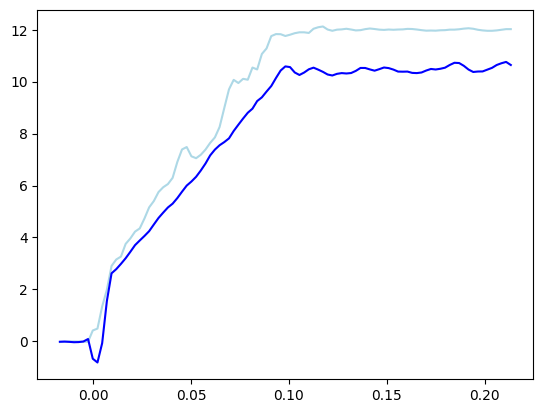

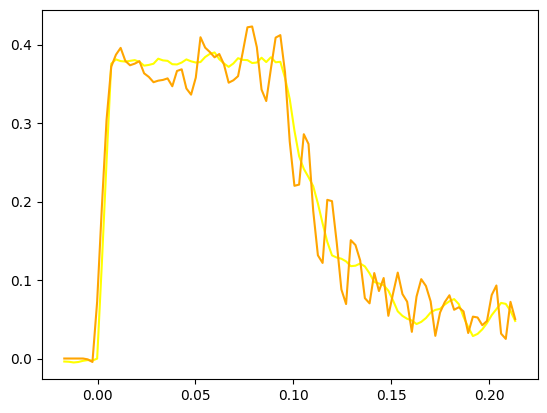

In [71]:
# Circuit Equation  
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w
# TL = Kt*i - Jm*dw/dt - Bm*w

Va_pred = Ia*Ra + La*dIa + Ke*Wm
Tm = Ke*Ia
Tm_pred = TL + Jm*dWm + Bm*Wm

plt.plot(t, Va, c="lightblue")
plt.plot(t, Va_pred, c="blue")
plt.show()

plt.plot(t, Tm, c="yellow")
plt.plot(t, Tm_pred, c="orange")
plt.show()